Iterasi 0, Loss: 338440973212893315072.0000
Iterasi 25, Loss: 336490984942986067968.0000
Iterasi 50, Loss: 334391814935422173184.0000
Iterasi 75, Loss: 332104654827787649024.0000
Iterasi 100, Loss: 329636154466407284736.0000
Iterasi 125, Loss: 326991380400861872128.0000
Iterasi 150, Loss: 324194222819799728128.0000
Iterasi 175, Loss: 321266109005822951424.0000
Iterasi 200, Loss: 318220725679674097664.0000
Iterasi 225, Loss: 315091533179209646080.0000
Iterasi 250, Loss: 311889333106660868096.0000
Iterasi 275, Loss: 308623238214398771200.0000
Iterasi 300, Loss: 305301305723631697920.0000
Iterasi 325, Loss: 301940037104869310464.0000


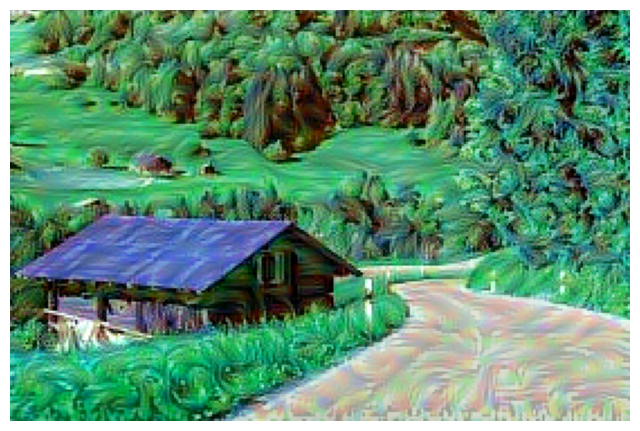

In [7]:
# Natural Style Transfer Improved Version (Stronger Blend + Object Mask)
# By ChatGPT

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# ------------------------------
# Load & preprocess image
# ------------------------------
def load_img(path):
    img = tf.keras.preprocessing.image.load_img(path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype("uint8")
    return x

content_path = "/content/drive/MyDrive/Colab Notebooks/Deep_learning_lanjut/dataset /images (1).jpg"
style_path   = "/content/drive/MyDrive/Colab Notebooks/Deep_learning_lanjut/dataset /pameran-lukisan-van-gogh-4.jpeg"

content_img = load_img(content_path)
style_img   = load_img(style_path)
gen_img     = tf.Variable(tf.cast(content_img, tf.float32))

# ------------------------------
# Create simple object mask (focus style on crocodile)
# ------------------------------
raw = cv2.imread(content_path)
gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 180, 1, cv2.THRESH_BINARY_INV)
mask = cv2.resize(mask, (content_img.shape[2], content_img.shape[1]))
mask = mask.astype("float32")
mask = np.expand_dims(mask, axis=0)
mask = np.expand_dims(mask, axis=-1)  # shape (1,H,W,1)
mask_tf = tf.constant(mask)

# ------------------------------
# VGG19 model load
# ------------------------------

vgg = vgg19.VGG19(weights="imagenet", include_top=False)
vgg.trainable = False

content_layers = ["block4_conv2"]
style_layers   = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
]

layers = content_layers + style_layers
outputs = [vgg.get_layer(l).output for l in layers]
model = Model(inputs=vgg.input, outputs=outputs)
model.trainable = False

# ------------------------------
# Feature extraction
# ------------------------------
def get_features(img):
    outputs = model(img)
    content_f = outputs[:len(content_layers)]
    style_f   = outputs[len(content_layers):]
    return content_f, style_f

content_target, _ = get_features(content_img)
_, style_target   = get_features(style_img)

# ------------------------------
# Loss functions
# ------------------------------
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    f = tf.reshape(x, (tf.shape(x)[0], -1))
    return tf.matmul(f, tf.transpose(f))

style_weight   = 3.0
content_weight = 1e4
tv_weight      = 150.0

@tf.function
def compute_loss(gen_img):
    content_f, style_f = get_features(gen_img)

    # Content loss with mask (focus on crocodile only)
    c_loss = 0
    for cf, ct in zip(content_f, content_target):
        c_loss += tf.reduce_mean(((cf - ct) ** 2) * tf.image.resize(mask_tf, (cf.shape[1], cf.shape[2])))

    # Style loss
    s_loss = 0
    for sf, st in zip(style_f, style_target):
        gram_s  = gram_matrix(st[0])
        gram_g  = gram_matrix(sf[0])
        s_loss += tf.reduce_mean((gram_g - gram_s) ** 2)

    # Smoothness (total variation)
    tv_loss = tf.image.total_variation(gen_img)

    total = (content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss)
    return total

# ------------------------------
# Optimization
# ------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)

@tf.function
def train_step(gen_img):
    with tf.GradientTape() as tape:
        loss = compute_loss(gen_img)
    grads = tape.gradient(loss, gen_img)
    optimizer.apply_gradients([(grads, gen_img)])
    gen_img.assign(tf.clip_by_value(gen_img, -128.0, 150.0))
    return loss

# ------------------------------
# Training loop
# ------------------------------
n_iter = 350
for i in range(n_iter):
    loss = train_step(gen_img)
    if i % 25 == 0:
        print(f"Iterasi {i}, Loss: {float(loss):.4f}")

# ------------------------------
# Show result
# ------------------------------
result = gen_img.numpy()
result = deprocess_img(result)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.axis("off")
plt.show()
